In [7]:
%load_ext autoreload
%autoreload 2

In [8]:
import numpy as np
import crocoddyl
import random
crocoddyl.switchToNumpyArray()

In [9]:
def data(nTraj:int = 1000,
         maxiter = 1000,
         precision = 1e-9,
         isFeasible:bool = False,
         regInit=.1,
         thetaVal:bool = False,
         fddp:bool = False
        ):
    """
    The dafault args that solver takes are  
    : init_xs=[]
    : init_us=[]
    : maxiter=1000
    : isFeasible=False
    : regInit=None. Initial guess for the regularization value. Very low values are typical
                   used with very good guess points (init_xs, init_us).\n
    
    """
    
    model = crocoddyl.ActionModelUnicycle()
    x_data = []
    y_data = []
    
    for _ in range(nTraj):

        if thetaVal:
            initial_config = [random.uniform(-1.99, 1.99), random.uniform(-1.99, 1.99), random.uniform(0.,1.)]
        else:
            initial_config = [random.uniform(-1.99, 1.99), random.uniform(-1.99, 1.99), 0.0]
        model.costWeights = np.matrix([1, 0.3]).T
        problem = crocoddyl.ShootingProblem(np.matrix(initial_config).T, [ model ] * 30, model)
        if fddp:
            ddp = crocoddyl.SolverFDDP(problem)
        else:
            ddp = crocoddyl.SolverDDP(problem)
            
        ddp.th_stop = precision    
        ddp.solve([], [], maxiter, isFeasible)
        if ddp.iter < 1000:
            xs = np.array(ddp.xs)
            us = np.array(ddp.us)
            i = []
            for d in ddp.datas():
                i.append(d.cost)
            for index, value in enumerate(i):
                i[index] = sum(i[index:])
                
            i = np.array(i).reshape(31, 1)    
            xs = np.hstack((xs[1:,:],us, i[1:,:]))  
        y_data.append(xs.ravel())   
        x_data.append(initial_config)
        
    x_data = np.array(x_data)
    y_data = np.array(y_data)
    del model, ddp
    return x_data, y_data

In [11]:
"""
This will define a neural net
"""
from keras import backend as K 
K.clear_session()
from keras import regularizers
from keras import optimizers
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
import matplotlib.pyplot as plt
from plot_keras_history import plot_history
from extra_keras_utils import is_gpu_available
from keras.utils import plot_model



def rmse(y_true, y_pred):
	return K.sqrt(K.mean(K.square(y_pred - y_true), axis=-1))

def max_error(y_true, y_pred):
    """
    Best score = 0
    """
    return K.max(K.abs(y_true - y_pred))


def kerasNet(x_data,
             y_data,
             NUNITS_INPUT = 16,
             NUNITS = 16,
             NHIDDEN = 2,
             lr = 1e-3,
             EPOCHS = 100,
             BATCHSIZE = 2,
             validation_split = 0.01,
             VERBOSE = 2,
             optimizer:str = "adam",
             loss = ['mean_squared_error'],
             plot_results:bool = True,
             baseline:bool = False                     
            ):
    """
    2 hidden layers, sigmoid tanh
    
    """

    model = Sequential()
    model.name = "Baseline"
    model.add(Dense(NUNITS_INPUT, input_dim=(x_data.shape[1]), activation = "relu", name="First"))
    for _ in range(NHIDDEN):
       
        model.add(Dense(NUNITS,
                        activation = "tanh",
                        kernel_initializer = 'glorot_uniform',
                        bias_initializer = 'random_normal',
                        kernel_regularizer=regularizers.l2(0.01),
                        activity_regularizer=regularizers.l1(0.01)    
                        )) 
            

    model.add(Dense(y_data.shape[1],                    
                   activation = 'linear',
                   name = "Final"))

    model.compile(loss='mse',
                  optimizer=optimizer,
                  metrics = [rmse, max_error, 'mae']
                  )
        

    
    print("X_Train : ", x_data.shape," and Y_Train: ", y_data.shape)
    history = model.fit(x_data, 
                        y_data,
                        validation_split = validation_split,
                        epochs = EPOCHS,
                        batch_size= BATCHSIZE,
                        verbose = VERBOSE
                        ).history
    
    print(model.summary())
    plot_history(history)

    return model

Using TensorFlow backend.
/home/aparag/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/aparag/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/aparag/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/aparag/.local/lib/python3.6/site-packages/tensorflow/python

In [15]:

def plot(net, STOP):
    data_iterations =[]
    for _ in range(50):
        a, b, c = random.uniform(-1.99, 1.99), random.uniform(-1.99, 1.99), 0.0
        starting_state =  [a, b, c]
        x_test = np.array(starting_state).reshape(1, -1)
        y_pred = net.predict(x_test)
        result = y_pred.reshape(30, 6)


        init_xs = []
        init_us =[]
        init_xs.append(np.array(starting_state))
        for row in result:
            init_xs.append(row[0:3])
            init_us.append(row[3:5])




        # For comparision, both models are given the same problem. The only difference is in ddp.solve.
        iterations = []
        #...... WARMSTARTING CROCODDYL
        model = crocoddyl.ActionModelUnicycle()
        model.costWeights = np.matrix([1, 0.3]).T
        problem = crocoddyl.ShootingProblem(np.matrix(starting_state).T, [ model ] * 30, model)
        ddp = crocoddyl.SolverDDP(problem)
        ddp.th_stop = STOP

        maxiter = 1000
        regInit = 0.01
        ddp.solve(init_xs, init_us, maxiter, False, regInit) 
            #plt.scatter(starting_state[0], starting_state[1])


        #..... COLDSTARTING CROCODDYL    
        model2 = crocoddyl.ActionModelUnicycle()
        model2.costWeights = np.matrix([1, 0.3]).T
        problem2 = crocoddyl.ShootingProblem(np.matrix(starting_state).T, [ model2 ] * 30, model2)
        ddp2 = crocoddyl.SolverDDP(problem2)
        ddp2.th_stop = 1e-9
        ddp2.solve([], [], 1000)


        #.. Storing the number of iterations it took when warmstarting and coldstarting
        data = [a, b, ddp.iter, ddp2.iter]    
        data_iterations.append(data)


    data = np.array(data_iterations)


    import matplotlib.pyplot as plt
    import matplotlib as mpl
    import seaborn as sns
    sns.set_style("whitegrid")
    mpl.rcParams['figure.dpi'] = 100
    %matplotlib inline

    fig=plt.figure(figsize=(8,6))
    plt.xlim(xmin=-2.1, xmax=2.1)
    plt.ylim(ymin=-2.1, ymax=2.1)
    plt.scatter(data[:,0], data[:,1], c = data[:,2], 
               cmap = 'winter', alpha = 0.8, linewidths = 0)
    cbar = plt.colorbar()
    cbar.set_label('iterations')
    plt.title(f"Warmstarted Croc, ddp.th_stop = {ddp.th_stop}")

    plt.savefig(f"./xsus/warmstarted{ddp.th_stop}.png")
    plt.show()


    import matplotlib.pyplot as plt
    import matplotlib as mpl
    import seaborn as sns
    sns.set_style("whitegrid")
    mpl.rcParams['figure.dpi'] = 90
    %matplotlib inline

    fig=plt.figure(figsize=(8,6))
    plt.xlim(xmin=-2.1, xmax=2.1)
    plt.ylim(ymin=-2.1, ymax=2.1)
    plt.scatter(data[:,0], data[:,1], c = data[:,3],
                cmap = 'winter', alpha = 0.8, linewidths = 0)
    plt.title(f"Coldstarted Croc, ddp.th_stop = {ddp2.th_stop}")
    cbar = plt.colorbar()
    cbar.set_label('iterations')
    plt.savefig(f"./xsus/coldStarted{ddp.th_stop}.png")
    plt.show()
    





In [ ]:
x, y = data(1000)

X_Train :  (1000, 3)  and Y_Train:  (1000, 180)

Model: "Baseline"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
First (Dense)                (None, 16)                64        
_________________________________________________________________
dense_1 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_2 (Dense)              (None, 16)                272       
_________________________________________________________________
Final (Dense)                (None, 180)               3060      
Total params: 3,668
Trainable params: 3,668
Non-trainable params: 0
_________________________________________________________________
None


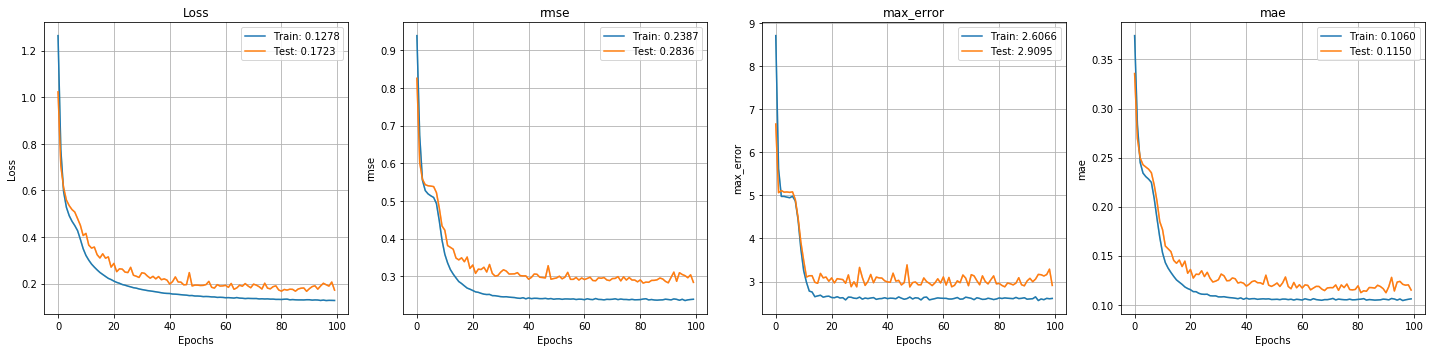

In [13]:
net = kerasNet(x, y, VERBOSE = 0)

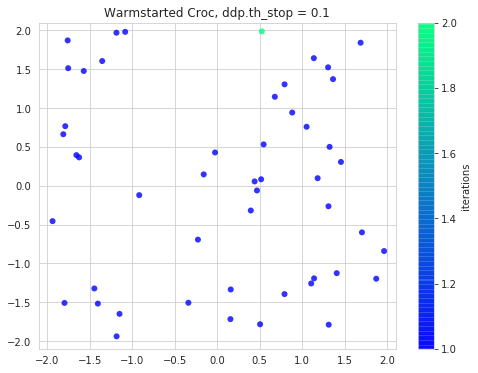

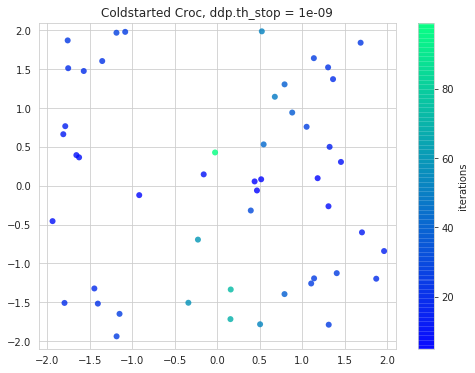

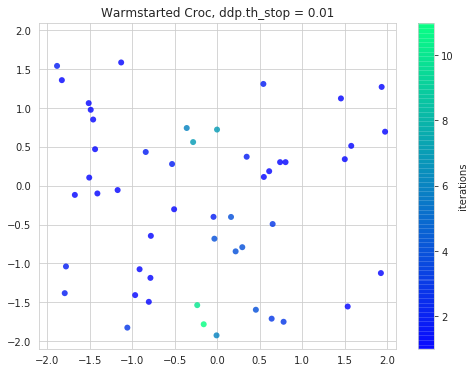

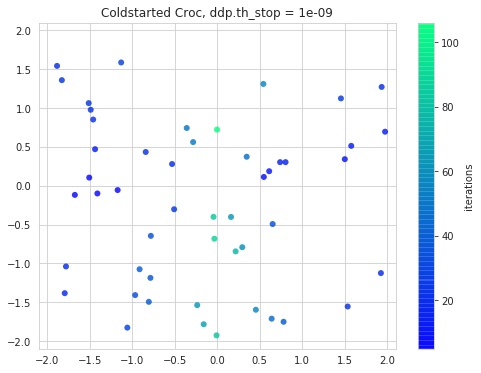

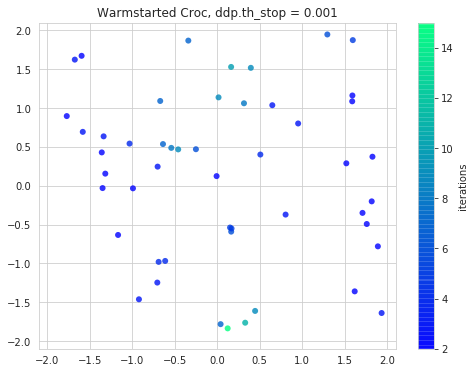

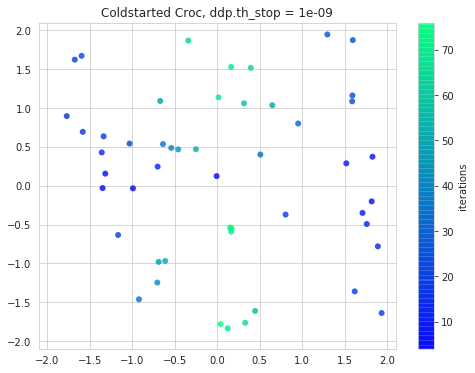

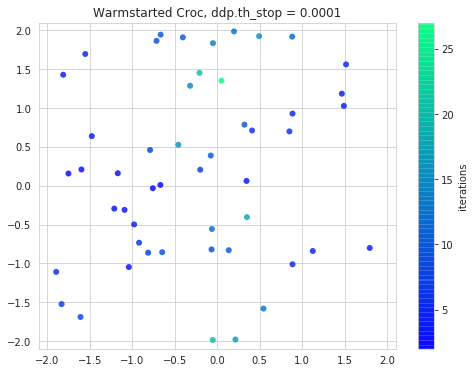

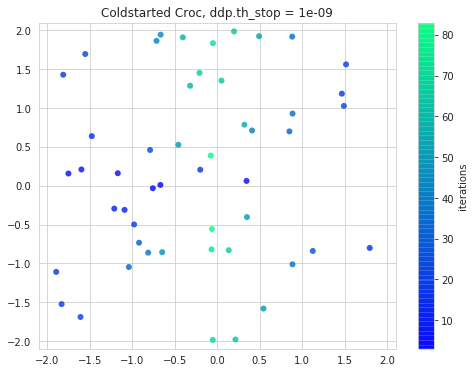

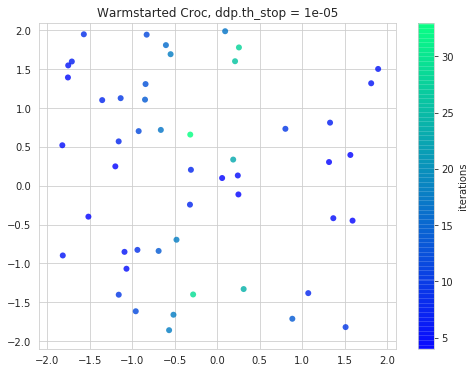

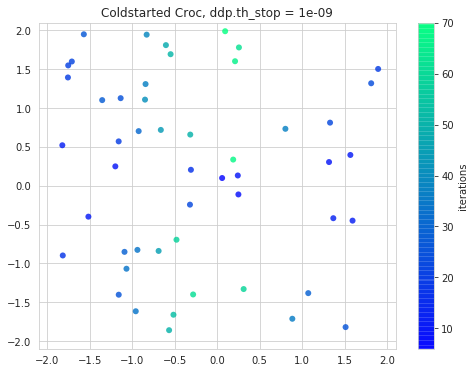

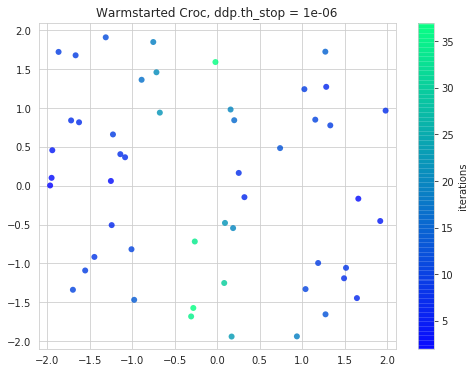

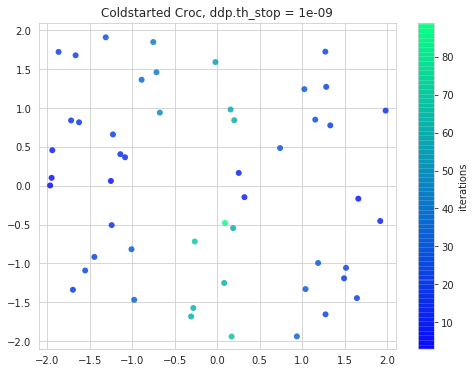

In [16]:
s = [1e-1, 1e-2, 1e-3, 1e-4, 1e-5, 1e-6]
for th_stop in s:
    plot(net,th_stop)

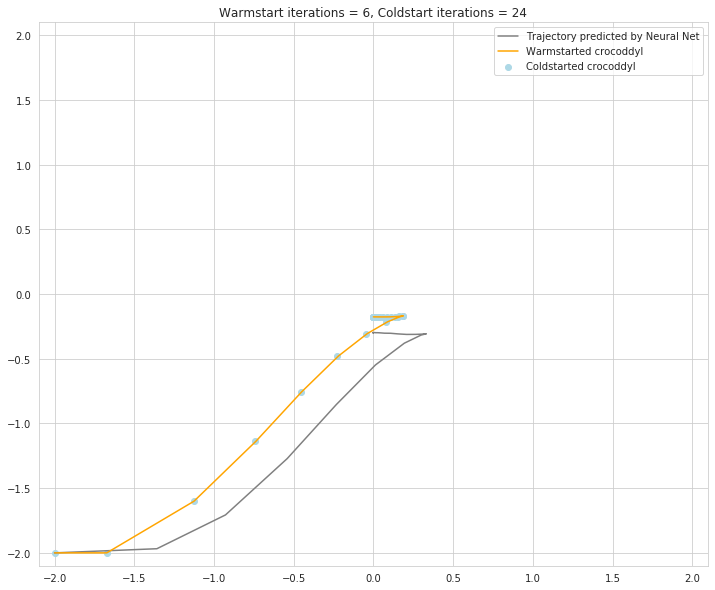

In [25]:
starting_state =  [-2, -2., 0]
x_test = np.array(starting_state).reshape(1, -1)
y_pred = net.predict(x_test)
result = y_pred.reshape(30, 6)


init_xs = []
init_us =[]
init_xs.append(np.array(starting_state))
for row in result:
    init_xs.append(row[0:3])
    init_us.append(row[3:5])




# For comparision, both models are given the same problem. The only difference is in ddp.solve.
iterations = []
#...... WARMSTARTING CROCODDYL
model = crocoddyl.ActionModelUnicycle()
model.costWeights = np.matrix([1, 0.3]).T
problem = crocoddyl.ShootingProblem(np.matrix(starting_state).T, [ model ] * 30, model)
ddp = crocoddyl.SolverDDP(problem)
ddp.th_stop = 1e-3

maxiter = 1000
regInit = 0.01
ddp.solve(init_xs, init_us, maxiter, False, regInit) 
    #plt.scatter(starting_state[0], starting_state[1])


#..... COLDSTARTING CROCODDYL    
model2 = crocoddyl.ActionModelUnicycle()
model2.costWeights = np.matrix([1, 0.3]).T
problem2 = crocoddyl.ShootingProblem(np.matrix(starting_state).T, [ model2 ] * 30, model2)
ddp2 = crocoddyl.SolverDDP(problem2)
ddp2.th_stop = 1e-9
ddp2.solve([], [], 1000)


ddp_xs = np.array(ddp.xs)
ddp2_xs = np.array(ddp2.xs)
init_xs = np.array(init_xs)

import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
sns.set_style("whitegrid")
mpl.rcParams['figure.dpi'] = 90
%matplotlib inline
fig=plt.figure(figsize=(12,10))
ax=fig.add_subplot(111)
ax.set_xlim(xmin=-2.1, xmax=2.1)
ax.set_ylim(ymin=-2.1, ymax=2.1)
ax.plot(init_xs[:,0], init_xs[:,1], c = 'grey', label = 'Trajectory predicted by Neural Net')
ax.plot(ddp_xs[:,0], ddp_xs[:,1], c = 'orange', label = 'Warmstarted crocoddyl')
ax.scatter(ddp2_xs[:,0], ddp2_xs[:,1], c = 'lightblue', label = 'Coldstarted crocoddyl')
plt.legend()
plt.title(f"Warmstart iterations = {ddp.iter}, Coldstart iterations = {ddp2.iter}" )
plt.savefig(f"./xsus/t2{ddp.th_stop}.png")

plt.show()


In [ ]:
import multiprocessing as mp

def _try_multiprocess(args_list, num_cpu, max_process_time, max_timeouts):
    # Base case
    if max_timeouts == 0:
        return None

    if num_cpu == 1:
        results = [generate_paths_star(args_list[0])]  # dont invoke multiprocessing unnecessarily

    else:
        pool = mp.Pool(processes=num_cpu, maxtasksperchild=1)
        parallel_runs = [pool.apply_async(generate_paths_star,
                                         args=(args_list[i],)) for i in range(num_cpu)]
        try:
            results = [p.get(timeout=max_process_time) for p in parallel_runs]
        except Exception as e:
            print(str(e))
            print("Timeout Error raised... Trying again")
            pool.close()
            pool.terminate()
            pool.join()
            return _try_multiprocess(args_list, num_cpu, max_process_time, max_timeouts - 1)

        pool.close()
        pool.terminate()
        pool.join()

    return results